# Introudction to Spatial Regreesion Models in Python

In this note, we will demo how spatial autocorrelation influences regreesion results. We use two data sources: (1) **Columbus home values** with relation to **income** and **crime** by neighborhood, i.e. y = **home values**, x = **income** + **crime**, and (2) **Austin house price** and other features listed in AirBnb.

     A. Columbus Data
         A.1 Ordinary Least Squares (OLS)
         A.2 Spatial autocorrelation - Global Moran's I
         A.3 Spatial Lagged y Regression (Wy)
         A.4 Spatial Error Regression (We)
     B. Austin Data
         B.1 Spatial autocorrelation - Global Moran's I
         B.2 OLS
         B.3 Spatially lagged y regression (Wy)
         B.4 Spatially lagged variable regression (WX)
         B.5 Spatially lagged variable and y regression (WX+Wy)


### Reference

1. Official site of spatial regression in pysal $-$ [Spatial regression](http://pysal.readthedocs.io/en/latest/library/spreg/twosls_sp.html) and [spatial regression Diagnostics](http://pysal.readthedocs.io/en/latest/library/spreg/).
2. [Youtube introduction](https://www.youtube.com/watch?v=6qZgchGCMds).
3. [Introduction to spatial regression](https://earthdatascience.org/tutorials/intro-to-spatial-regression/).
4. [Spatial Regression](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html).
5. [Why do we consider spatial lag?](https://blogs.iq.harvard.edu/spatial_lag_1)

In [169]:
import pysal
import numpy as np
import pandas as pd
from pysal.spreg import ols
from pysal.spreg import ml_error
from pysal.spreg import ml_lag
from pysal.spreg.twosls_sp import GM_Lag
import pysal.spreg.diagnostics as D

from sklearn.metrics import mean_squared_error as mse

from scipy import stats

import matplotlib
#matplotlib.use("nbagg") #this allows for plotting to happen inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline

# A. Columbus Data

The codes and data are followed from the tutorial pages [Introduction to spatial regression](https://earthdatascience.org/tutorials/intro-to-spatial-regression/) at EarthLab.

In [330]:
f = pysal.open(pysal.examples.get_path("columbus.dbf"),'r')
y = np.array(f.by_col['HOVAL'])
y.shape = (len(y),1)

The feature variables include:

In [331]:
f.header

[u'AREA',
 u'PERIMETER',
 u'COLUMBUS_',
 u'COLUMBUS_I',
 u'POLYID',
 u'NEIG',
 u'HOVAL',
 u'INC',
 u'CRIME',
 u'OPEN',
 u'PLUMB',
 u'DISCBD',
 u'X',
 u'Y',
 u'NSA',
 u'NSB',
 u'EW',
 u'CP',
 u'THOUS',
 u'NEIGNO']

Among the features, we only consider two variables, `income` and `crime`:

In [332]:
X= []
X.append(f.by_col['INC'])
X.append(f.by_col['CRIME'])
X = np.array(X).T
X.shape

(49, 2)

Now X (feature) turns to a $49\times 2$ numpy matrix, and each row denotes an observation.

In [25]:
X[:5]

array([[ 19.531   ,  15.72598 ],
       [ 21.232   ,  18.801754],
       [ 15.956   ,  30.626781],
       [  4.477   ,  32.38776 ],
       [ 11.252   ,  50.73151 ]])

## A.1 Ordinary Least Squares (OLS)

OLS is a linear regression model assuming all data are independent each other. The model reads

$$y=\beta X +\epsilon$$

Here y = `HOVAL` and X = (`INC` and `CRIME`).

In [333]:
ls = ols.OLS(y, X, name_y = 'home val', name_x = ['Income', 'Crime'], name_ds = 'Columbus')
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :    Columbus
Weights matrix      :        None
Dependent Variable  :    home val                Number of Observations:          49
Mean dependent var  :     38.4362                Number of Variables   :           3
S.D. dependent var  :     18.4661                Degrees of Freedom    :          46
R-squared           :      0.3495
Adjusted R-squared  :      0.3212
Sum squared residual:   10647.015                F-statistic           :     12.3582
Sigma-square        :     231.457                Prob(F-statistic)     :   5.064e-05
S.E. of regression  :      15.214                Log likelihood        :    -201.368
Sigma-square ML     :     217.286                Akaike info criterion :     408.735
S.E of regression ML:     14.7406                Schwarz criterion     :     414.411

-----------------------------------------------------------------------------

The regression shows the **house price** is inversely monotonic upon **crime rate**. One unit of increased crime rate results in decreased price (in unit of 0.62) on **home price**. The **income** however does not have significant impact to the **Columbus house price**; the p-value is larger than 0.05. The mean square error is

In [334]:
mse(y.flatten(), ls.predy.flatten())

217.28602192257543

** Note that the multiollinearity condition number is 12!** That indicates that there exists correlation between `INC` and `CRIME` features. We can further examine the Pearson correlation coefficient:

In [31]:
print stats.pearsonr(f.by_col['INC'], f.by_col['CRIME'])

(-0.69558977345846218, 2.9010250086454949e-08)


We see the correlation magnitude is about 0.7; indicating strong correlation. The negative sign means areas where house owners with higher income have lower crime rates.

## A.2 Spatial autocorrelation - Global Moran's I

OLS regression assumes that each observation is independent from all others. However, in practice, locations that are near each other are not likely to be independent, i.e. expansive houses are close to expansive houses. To quantitively examine if there exists spatial autocorrelation in house price, we evaluate spatial autocorrelation in the residuals with Moran’s I test. First prepare the weight matrix:

In [335]:
w = pysal.open(pysal.examples.get_path("columbus.gal")).read()
type(w), w.pct_nonzero

(pysal.weights.weights.W, 9.82923781757601)

In [336]:
weight, ids = w.full()
print type(weight), weight.shape

<type 'numpy.ndarray'> (49, 49)


In [38]:
weight

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [298]:
w2 = pysal.rook_from_shapefile(pysal.examples.get_path("columbus.shp"))
type(w2), w2.pct_nonzero

(pysal.weights.Contiguity.Rook, 8.329862557267806)

In [41]:
weight, ids = w2.full()
print type(weight), weight.shape
print weight

<type 'numpy.ndarray'> (49, 49)
[[ 0.  1.  1. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]
 [ 1.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


To verify whether there is spatial correlation in our **model target** `home value`, we compute the Moran's I for `y` 

In [337]:
mi = pysal.Moran(y, w, two_tailed=False)
print "Moran's I = %.3f" %round(mi.I,3), ', Z-score = %.3f'%round(mi.z_norm,3), ', p-value = %.3f' %round(mi.p_norm,3)

Moran's I = 0.180 , Z-score = 2.171 , p-value = 0.015


On the other hand, to verify whether there is spatial correlation in our **model residuals**, we compute Moran's I for `ls.u`

In [310]:
mi = pysal.Moran(ls.u, w, two_tailed=False)
print "Moran's I = %.3f" %round(mi.I,3), ', Z-score = %.3f'%round(mi.z_norm,3), ', p-value = %.3f' %round(mi.p_norm,3) 

Moran's I = 0.171 , Z-score = 2.076 , p-value = 0.019


From small values of Moran's I, we can interpret weak spatial autocorrelation on target and model residuals. Therefore we cannot expect significant model improvement using spatial regreesion models. In the following we will demontrate this behavior.

## A.3 Spatial lagged y regression (Wy)

This model considers spatially lagged target, i.e. average house price over a house. The model reads as

$$y=\rho W y+\beta X +\epsilon,$$

where $\rho W y$ denotes the spatially lagged y. In the followings, we implement maximum likelihood and spatial two stage least squares to solve models. Both of them are available in `pysal`.

###  Maximum likelihood spatial lag

In [342]:
spat_lag1 = ml_lag.ML_Lag(y, X, w, 
                             name_y='home value', name_x=['income','crime'], 
                             name_w='columbus.gal', name_ds='columbus home spatial regression')
print(spat_lag1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :columbus home spatial regression
Weights matrix      :columbus.gal
Dependent Variable  :  home value                Number of Observations:          49
Mean dependent var  :     38.4362                Number of Variables   :           4
S.D. dependent var  :     18.4661                Degrees of Freedom    :          45
Pseudo R-squared    :      0.3668
Spatial Pseudo R-squared:  0.3315
Sigma-square ML     :     211.532                Log likelihood        :    -200.880
S.E of regression   :      14.544                Akaike info criterion :     409.760
                                                 Schwarz criterion     :     417.328

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------

In [343]:
mse(y.flatten(), spat_lag1.predy.flatten())

211.53169092723425

###  Spatial two stage least squares

In [344]:
spat_reg2 = GM_Lag(y, X, w=w, w_lags=2, robust='white', name_x=['income', 'crime'], name_y='home value', name_ds='columbus')
print spat_reg2.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :    columbus
Weights matrix      :     unknown
Dependent Variable  :  home value                Number of Observations:          49
Mean dependent var  :     38.4362                Number of Variables   :           4
S.D. dependent var  :     18.4661                Degrees of Freedom    :          45
Pseudo R-squared    :      0.3331
Spatial Pseudo R-squared:  0.3557

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      50.1960005      20.3474921       2.4669379       0.0136274
              income       0.6566632       0.4961750       1.3234508       0.1856855
               crime      -0.4967880 

In [346]:
mse(y.flatten(), spat_reg2.predy.flatten())

222.86845260707244

In [347]:
spat_reg2.betas

array([[ 50.1960005 ],
       [  0.65666318],
       [ -0.49678804],
       [ -0.09745662]])

In [350]:
spat_reg2.std_err

array([ 20.34749212,   0.49617498,   0.19881162,   0.36253875])

**Summary**

We see with the spatially lagged target terms, the coefficients of **income** and **crime** do not have significant difference; **income** is still statistically insignificant. 

Both spatial regression models show the **spatially lagged home values** are insignificant. Therefore, the spatial regression is not better than the OLS. This observation is consisitent with a small Moran's I on target value.

The ML-spatially lagged y regression gives lowest MSE.

## A.4 Spatial error regression ($W\epsilon$)

$$y = \lambda W\epsilon + \beta X + \epsilon$$

In [351]:
spat_err = ml_error.ML_Error(y, X, w, 
                             name_y='home value', name_x=['income','crime'], 
                             name_w='columbus.gal', name_ds='columbus')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :    columbus
Weights matrix      :columbus.gal
Dependent Variable  :  home value                Number of Observations:          49
Mean dependent var  :     38.4362                Number of Variables   :           3
S.D. dependent var  :     18.4661                Degrees of Freedom    :          46
Pseudo R-squared    :      0.3495
Sigma-square ML     :     197.314                Log likelihood        :    -199.769
S.E of regression   :      14.047                Akaike info criterion :     405.537
                                                 Schwarz criterion     :     411.213

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

Now, with considering spatially lagged errors, $\lambda$ is slightly below 0.05, and contirbute to the regression models. 

In [352]:
mse(y.flatten(), spat_err.predy.flatten())

219.90604442609077

The MSE is even slightly worse than OLS.

# B. Austin Data

This part implement home value data from [Airbnb](http://insideairbnb.com/get-the-data.html). Here we follow the [tutorial lectures](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html).

In [355]:
austin_data = pd.read_csv('listings.csv')
austin_data.shape

(9663, 95)

In [356]:
austin_data = austin_data[['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'amenities', 'price', 'longitude', 'latitude']].dropna()
austin_data.shape

(9611, 9)

In [357]:
austin_data.columns

Index([u'host_listings_count', u'bathrooms', u'bedrooms', u'beds',
       u'guests_included', u'amenities', u'price', u'longitude', u'latitude'],
      dtype='object')

In [358]:
def has_pool(a):
    if 'Pool' in a:
        return 1
    else:
        return 0

austin_data['pool'] = austin_data['amenities'].apply(has_pool)
austin_data['price'] = austin_data['price'].apply(lambda x: float(x.strip('$').replace(',', '')))

In [360]:
X = austin_data[['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'pool']]
X.head()

,host_listings_count,bathrooms,bedrooms,beds,guests_included,pool
0,1.0,2.0,3.0,4.0,1,0
1,1.0,2.0,3.0,5.0,8,0
2,1.0,1.0,1.0,2.0,4,0
3,3.0,3.0,4.0,5.0,1,0
4,1.0,1.0,1.0,1.0,1,0


In [359]:
y = austin_data['price']
y = np.array(y.tolist())
y.shape = (len(y),1)  ## since pysal spatial regression only accpets all input as two-D array, this step is necessary
                      ## otherwise Y is only an one-D array.

### Spatial weight matrix w

Here we create the spatial weight matrix using [`knnW_form_array`](http://pysal.readthedocs.io/en/latest/library/weights/user.html#pysal.weights.user.knnW_from_array) model in pysal. In the default setting, $k=p=2$. k means the number of nearest neighbors; $p=2$ uses Euclidean distance and $p=1$ uses Manhattan distance. Weights object returns with binary weights.

In [362]:
w = pysal.knnW_from_array(austin_data.loc[austin_data.index, ['longitude', 'latitude']].values) # default k=2
w.transform = 'R' # row-normalize the weight matrix
w

In [363]:
w.n

9611

In [215]:
weight, ids = w.full()

In [216]:
weight

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [217]:
w.pct_nonzero

0.02080948912704193

## B.1 Spatial autocorrelation - Global Moran's I

In [364]:
df = austin_data[['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'pool', 'price']]

attribute, I, Z, pv = [], [], [], []
for feature in df.columns:
    mi = pysal.Moran(np.array(df[feature].tolist()), w)
    attribute.append(feature)
    I.append(round(mi.I, 3))
    Z.append(round(mi.z_norm, 3))
    pv.append(round(mi.p_norm, 3))
    
pd.DataFrame({'Feature': attribute, "Moran's I": I, 'Z-score':Z, 'p-value': pv})

,Feature,Moran's I,Z-score,p-value
0,host_listings_count,0.048,5.153,0.0
1,bathrooms,0.164,17.521,0.0
2,bedrooms,0.129,13.765,0.0
3,beds,0.134,14.269,0.0
4,guests_included,0.051,5.488,0.0
5,pool,0.457,48.802,0.0
6,price,0.118,12.606,0.0


There exists weak but significant spatial correlation on **price** and **pool** has stronger spatial correlation.

## B.2 OLS

$$y=\beta X +\epsilon$$

In [365]:
ls = ols.OLS(y, X.values, 
             name_y = 'price', 
             name_x = ['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included','pool'], 
             name_ds = 'Austin home price')
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Austin home price
Weights matrix      :        None
Dependent Variable  :       price                Number of Observations:        9611
Mean dependent var  :    292.4530                Number of Variables   :           7
S.D. dependent var  :    442.9359                Degrees of Freedom    :        9604
R-squared           :      0.3271
Adjusted R-squared  :      0.3267
Sum squared residual:1268604993.394                F-statistic           :    778.2517
Sigma-square        :  132091.315                Prob(F-statistic)     :           0
S.E. of regression  :     363.444                Log likelihood        :  -70296.763
Sigma-square ML     :  131995.109                Akaike info criterion :  140607.526
S.E of regression ML:    363.3113                Schwarz criterion     :  140657.720

----------------------------------------------------------------------

Results show that both one extra **bedroom** and one **extra bathroom** increase the final price $\$190$ and $\$82$, respectively. Accounting for those, an extra **bed** pushes $\$21$ more and pool will contirbute additional $\$65$ dollars. However, neither the **number of guests** included nor the **number of listings the host** has in total have a significant effect on the final price. $R^2=0.3271$ and adjusted $R^2=0.3267$.

### Transform target y with log function

Actually the **target y** is not normal distributed. For OLS, we can transform it to a normal distribution by taking log function:

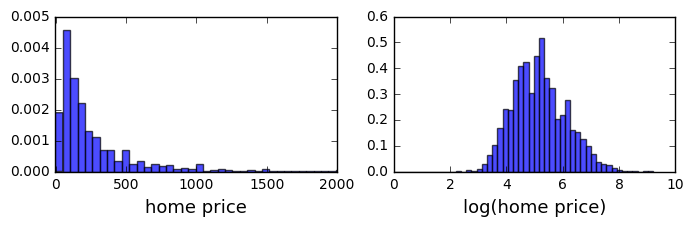

In [372]:
plt.subplots(nrows=1, ncols=2, figsize = (8,2))
bins = np.linspace(-0.5, max(y)+0.5, len(y)/50)

ax = plt.subplot(121)
plt.hist(y[:,0], bins=bins, alpha=0.7, label='', normed=True)
plt.xlabel('home price', fontsize = 13)
plt.xlim(-0.5, 2000)

ax = plt.subplot(122)
plt.hist(np.log(y[:, 0]+0.0001), bins=100, alpha=0.7, label='', normed=True)
plt.xlabel('log(home price)', fontsize = 13)
plt.xlim(0, )

plt.show()

In [373]:
log_y = np.log(y[:, 0]+0.0001)
log_y.shape = (len(log_y), 1)

In [376]:
log_ols_reg = ols.OLS(log_y, X.values, 
             name_y = 'log(price)', 
             name_x = ['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included','pool'], 
             name_ds = 'Austin home price')
print(log_ols_reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Austin home price
Weights matrix      :        None
Dependent Variable  :  log(price)                Number of Observations:        9611
Mean dependent var  :      5.1712                Number of Variables   :           7
S.D. dependent var  :      0.9667                Degrees of Freedom    :        9604
R-squared           :      0.4167
Adjusted R-squared  :      0.4163
Sum squared residual:    5238.184                F-statistic           :   1143.5150
Sigma-square        :       0.545                Prob(F-statistic)     :           0
S.E. of regression  :       0.739                Log likelihood        :  -10720.799
Sigma-square ML     :       0.545                Akaike info criterion :   21455.599
S.E of regression ML:      0.7383                Schwarz criterion     :   21505.793

------------------------------------------------------------------------

Results show that **bedroom**, **bathroom**, **bed** and existence of **pool** are still significant to the final price. By with **log(price)**, it is clear to see neither the **number of guests included** nor the **number of listings the host** has in total have a significant effect on the final price. However now $R^2=0.4167$ and adjusted $0.4163$, so the current OLS model (using **log[price]**) is a better model to explain variance than the previous one (using **price**).

In [187]:
ls.predy

array([[ 5.74535391],
       [ 5.75283864],
       [ 4.72254826],
       ..., 
       [ 5.06044959],
       [ 4.79071346],
       [ 6.07312055]])

In [377]:
mse(log_y.flatten(), log_ols_reg.predy.flatten())

0.54501961939237265

## B.3 Spatially lagged y regression (Wy)

This model additionally considers the spatially lagged y, i.e. the **log(house price)** surrounding a given property also enters its own price function. It reads as

$$y=\rho Wy+\beta X +\epsilon$$

Note that y = log(price). We still implement two methods for the model. Spatial two stage least squares and Maximum likelihood spatial lag.

### Spatial two stage least squares

In [388]:
lag_y_reg=GM_Lag(log_y, X.values, w=w, w_lags=2, robust='white', 
           name_x=['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included','pool'], 
           name_y='log(price)', 
           name_ds='Austin home price lag model')
print lag_y_reg.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :Austin home price lag model
Weights matrix      :     unknown
Dependent Variable  :  log(price)                Number of Observations:        9611
Mean dependent var  :      5.1712                Number of Variables   :           8
S.D. dependent var  :      0.9667                Degrees of Freedom    :        9603
Pseudo R-squared    :      0.4337
Spatial Pseudo R-squared:  0.4177

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       3.7213036       0.0757762      49.1091461       0.0000000
 host_listings_count      -0.0001057       0.0000970      -1.0904400       0.2755194
           bathrooms  

In [394]:
mse(log_y.flatten(), lag_y_reg.predy.flatten())

0.5292398954373202

The regression results are again very similar in all the other variable. However, it is also very clear that the estimate of the spatially lagged price is statistically significant and has about 30% impact (0.069) of pool (0.174). This points to evidence that there are processes of spatial interaction between property owners when they set their price.

### Maximum likelihood spatial lag

In addition to the GM_lag model, we can also implement maximum likelihood for the spatially lagged y model:

In [389]:
lag_y_reg2 = ml_lag.ML_Lag(log_y, X.values, w=w, 
                           name_y='log(home value)',
                           name_x=['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included','pool'], 
                           name_ds='Austin home spatial regression')
print(lag_y_reg2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Austin home spatial regression
Weights matrix      :     unknown
Dependent Variable  :log(home value)                Number of Observations:        9611
Mean dependent var  :      5.1712                Number of Variables   :           8
S.D. dependent var  :      0.9667                Degrees of Freedom    :        9603
Pseudo R-squared    :      0.4493
Spatial Pseudo R-squared:  0.4145
Sigma-square ML     :       0.515                Log likelihood        :  -10501.901
S.E of regression   :       0.717                Akaike info criterion :   21019.802
                                                 Schwarz criterion     :   21077.168

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------

In [390]:
mse(log_y.flatten(), lag_y_reg2.predy.flatten())

0.51462140251471711

The ML_Lag model spent much longer time to train the model but shows important impact on lagged log(home price). The former also gives lower MSE.

## B4. Spatially lagged variable regression (WX)

In a similar way, the spatially lagged variable model introduces "spatially lagging" of one of the explanatory variables into regression. It reads as

$$y=\lambda WX^{\prime} + \beta X +\epsilon$$

where $X^{\prime}$ is a subset of $X$. From Moran's I, the feature **pool** has significant spatial correlation, so we simply consider one spatially lagged variable, which is the spatially lagged pool. Even that, we can compare various number of neighbors to compute spatially lagged pool. Here we take k=2 and k=10.

### Number of neighbors k = 2

Using `knnW_from_array` to generate spatially lagged pool **lag_pool**. The default setting is k=2.

In [380]:
lag_pool = pysal.knnW_from_array(austin_data.loc[austin_data.index, ['longitude', 'latitude']].values)

In [381]:
X_lag_pool = X.assign(lag_pool=pysal.lag_spatial(lag_pool, X['pool'].values))

Now, in addition to the original dataframe, we add lagged pool feature `lag_pool`: 

In [382]:
X_lag_pool.head()

,host_listings_count,bathrooms,bedrooms,beds,guests_included,pool,lag_pool
0,1.0,2.0,3.0,4.0,1,0,0.0
1,1.0,2.0,3.0,5.0,8,0,0.0
2,1.0,1.0,1.0,2.0,4,0,0.0
3,3.0,3.0,4.0,5.0,1,0,0.0
4,1.0,1.0,1.0,1.0,1,0,0.0


In [383]:
lag_pool_reg = ols.OLS(log_y, X_lag_pool.values,
             name_y = 'log(price)', 
             name_x = ['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'pool', 'lag_pool'], 
             name_ds = 'Austin home price')
print(lag_pool_reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Austin home price
Weights matrix      :        None
Dependent Variable  :  log(price)                Number of Observations:        9611
Mean dependent var  :      5.1712                Number of Variables   :           8
S.D. dependent var  :      0.9667                Degrees of Freedom    :        9603
R-squared           :      0.4182
Adjusted R-squared  :      0.4178
Sum squared residual:    5224.624                F-statistic           :    986.1576
Sigma-square        :       0.544                Prob(F-statistic)     :           0
S.E. of regression  :       0.738                Log likelihood        :  -10708.344
Sigma-square ML     :       0.544                Akaike info criterion :   21432.688
S.E of regression ML:      0.7373                Schwarz criterion     :   21490.053

------------------------------------------------------------------------

In [384]:
mse(log_y.flatten(), lag_pool_reg.predy.flatten())

0.54360878711496963

In this model, the existence of **lag_pool** is statistically significant. We therefore can infer that there are processes of spatial interaction between number of **pools** and **spatial lagged of number of pools**. The spatially lagged variable regression model has lower MSE than OLS, but still higher than spatially lagged y regression model.

### Number of neighbors k = 10

In [385]:
lag_pool2 = pysal.knnW_from_array(austin_data.loc[austin_data.index, ['longitude', 'latitude']].values, k=10)
X_lag_pool2 = X.assign(lag_pool2=pysal.lag_spatial(lag_pool2, X['pool'].values))

In [386]:
lag_pool_reg2 = ols.OLS(log_y, X_lag_pool2.values,
             name_y = 'log(price)', 
             name_x = ['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'pool', 'lag_pool'], 
             name_ds = 'Austin home price')
print(lag_pool_reg2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Austin home price
Weights matrix      :        None
Dependent Variable  :  log(price)                Number of Observations:        9611
Mean dependent var  :      5.1712                Number of Variables   :           8
S.D. dependent var  :      0.9667                Degrees of Freedom    :        9603
R-squared           :      0.4194
Adjusted R-squared  :      0.4190
Sum squared residual:    5213.542                F-statistic           :    991.1701
Sigma-square        :       0.543                Prob(F-statistic)     :           0
S.E. of regression  :       0.737                Log likelihood        :  -10698.140
Sigma-square ML     :       0.542                Akaike info criterion :   21412.279
S.E of regression ML:      0.7365                Schwarz criterion     :   21469.644

------------------------------------------------------------------------

In [391]:
mse(log_y.flatten(), lag_pool_reg2.predy.flatten())

0.54245568931258692

## B5. Spatially lagged variable and y regression (WX+Wy)

The model is called spatially Durbin model. It reads
$$y=\lambda WX^{\prime} + \rho Wy+\beta X +\epsilon$$

In [392]:
lag_pool_y_reg = ml_lag.ML_Lag(log_y, X_lag_pool.values, w=w, 
                           name_y='log(home value)',
                           name_x=['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included','pool', 'lag_pool'], 
                           name_ds='Austin home spatial regression')
print(lag_pool_y_reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Austin home spatial regression
Weights matrix      :     unknown
Dependent Variable  :log(home value)                Number of Observations:        9611
Mean dependent var  :      5.1712                Number of Variables   :           9
S.D. dependent var  :      0.9667                Degrees of Freedom    :        9602
Pseudo R-squared    :      0.4501
Spatial Pseudo R-squared:  0.4156
Sigma-square ML     :       0.514                Log likelihood        :  -10494.106
S.E of regression   :       0.717                Akaike info criterion :   21006.211
                                                 Schwarz criterion     :   21070.747

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------

In [393]:
mse(log_y.flatten(), lag_pool_y_reg.predy.flatten())

0.51390994434064308

We can see by introducing both spatially lagged X and y, the regression model improves.